<a href="https://colab.research.google.com/github/onmax/bike-forecasting/blob/main/src/models/one_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/onmax/bike-forecasting/
%cd bike-forecasting/src/models

In [ ]:
!pip3 install tensorflow keras livelossplot tensorboard pandas >> /dev/null

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [14]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Reshape, Lambda

import sys

sys.path.insert(1, '../../preprocessing/')
sys.path.insert(1, '../../graphs/')
sys.path.insert(1, '..')
from window import WindowGenerator
from model_lib import compile_and_fit, model_generator
from dataset_lib import load_dataset, split_dataset
from lr import lr_timeline
# from predictions import plot_predictions


In [20]:
model_generator("simple_rnn", lr=10e-3)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/f/proyectos/bikes/src/models/recurrent/../../data/files/trips.csv'

In [2]:
df = load_dataset("/..")

Putting together /mnt/f/proyectos/bikes/src/models/recurrent/../../../data/files/../parts/chicago-divvy-trips-part-1
Putting together /mnt/f/proyectos/bikes/src/models/recurrent/../../../data/files/../parts/chicago-divvy-trips-part-2
Putting together /mnt/f/proyectos/bikes/src/models/recurrent/../../../data/files/../parts/chicago-divvy-trips-part-3


In [3]:
train_df, val_df, test_df = split_dataset(df)
num_features = train_df.shape[1] - 3

Training from 2017-01-01 00:00:00 to 2017-12-31 23:00:00
Validating from 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Testing from 2019-01-01 00:00:00 to 2019-12-31 23:00:00


In [4]:
num_features

633

In [7]:
OUT_STEPS = 3
input_width = 12
window = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df, val_df=val_df)

In [ ]:
model = tf.keras.Sequential([
    SimpleRNN(128, return_sequences=True),
    SimpleRNN(128),
    Dense(num_features)
])
history = compile_and_fit(model, window, should_stop=True, max_epochs=100, with_lr_schedule=True)

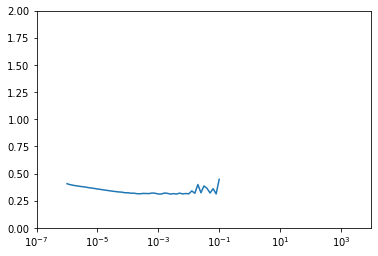

In [39]:
lr_timeline(history, [1e-7, 1e4, 0, 2]) 

In [12]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    Lambda(lambda x: x[:, -1:, :]),
    SimpleRNN(100, return_sequences=True),
    # SimpleRNN(100),
    Dense(128),
    Dropout(0.2),
    Dense(OUT_STEPS*num_features),
    Reshape([OUT_STEPS, num_features])

])
history = compile_and_fit(model, window, lr=10e-2, should_stop=False, max_epochs=100, tensorboard=True)

Epoch 1/100


KeyboardInterrupt: 

In [13]:
plot_predictions(window, model, 10)

ValueError: x and y must be the same size